# Getting started with monkeys

This guide will show you how to start using `monkeys` and introduce you to the `monkeys` type system. Let's imagine a scenario: we have a number of data points representing horsepower versus miles per gallon in cars made between 1970 and 1982, and want to discover an equation that best fits this relationship. First, let's visualize our data, as taken from the [Auto MPG data set](https://archive.ics.uci.edu/ml/datasets/Auto+MPG).

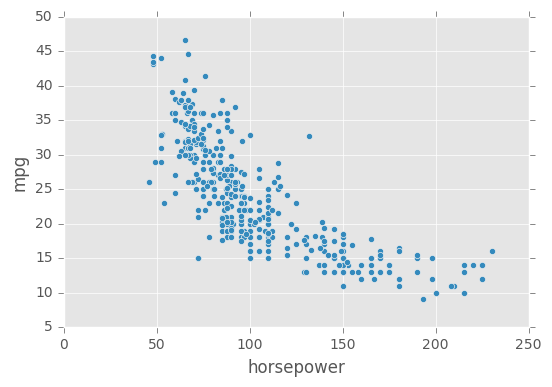

In [1]:
%matplotlib inline
import pandas
import matplotlib
matplotlib.style.use('ggplot')

df = pandas.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
    delimiter='\s+',
    header=None,
    names='mpg cylinders disp horsepower weight acceleration year origin name'.split(),
    na_values=['?'],
)
df.plot.scatter(x='horsepower', y='mpg')

## Specifying solution structure

As noted in the [`README.md`](https://github.com/hchasestevens/monkeys/blob/master/README.md), one of the requirements of using genetic programming is specifying what you want solutions to your problem to look like. In `monkeys`, this is accomplished through a rudimentary type system that allows you to restrict how functions can be composed together. By applying the `params` and `rtype` decorators to a function, you declare the types the function expects to receive as arguments and the type the function returns. 

Supposing we wanted to allow our equation to contain multiplication, division, addition, squaring, and negation, these could be declared as follows:

In [2]:
from monkeys.typing import params, rtype, ignore
import sys

@params(float, float)  # expects two floats
@rtype(float)  # returns a float
def multiply(a, b):
    return a * b

@params(float, float)
@rtype(float)
@ignore(sys.maxsize, ZeroDivisionError)  # in the event of division by zero, return infinity
def divide(a, b):
    return a / b

@params(float, float)
@rtype(float)
def add(a, b):
    return a + b

@params(float)  # expects only a single float
@rtype(float)
@ignore(sys.maxsize, OverflowError, ValueError, ZeroDivisionError)
def square(a):
    return a ** 2

@params(float)
@rtype(float)
def negate(a):
    return -a

The `params` decorator can also be used without specifying any types. In this case, the function can be run without supplying any parameters, and is known as a "terminal" node. When creating your system, you must supply at least one terminal node -- otherwise, `monkeys` won't have any "end point" at which it can stop constructing the program. In cases where we want to supply a single value of a certain type, without the need to define a function, we can use the `constant` function. Since we don't have any way of generating `float`s right now, let's declare a few.

In [3]:
from monkeys.typing import constant

one = constant(float, 1.0)
two = constant(float, 2.0)

We also need a means of providing input to our program. This can be done using the `make_input` function, which requires us to specify the input's type, as well as the input's initial value and name optionally. 

In [4]:
from monkeys.trees import make_input

horsepower = make_input(float, name='horsepower')

We may also want to specify for clerical reasons an "Equation" type, which can be made from any program returning a float:

In [5]:
@params(float)
@rtype('Equation')  # monkeys will, if provided a string, make a new type for us
def equation(a):
    return a

If we want to, we can now visualize the system we've set up using `type_graph`. Note that this requires `graphviz` to be installed.

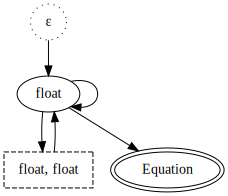

In [6]:
from monkeys.display import type_graph

type_graph()

This diagram shows the relationship between our types, and what we can construct from what. The ε at the top of the diagram in a dotted circle represents "nothing" -- this is to say, we can create `float`s out of thin air, by using our constants or our horsepower input. `float`s can be made into `float`s directly (via `negate`), or can be combined with other `float`s (resulting in a synthetic `(float, float)` type, represented as a dashed rectagle) to make `floats`, via `multiply`, `divide`, etc. If there is an obvious type we might want to generate, as is the case with `Equation`, `monkeys` will double-circle this to indicate as much.

## Scoring solutions

Now that we've specified how solutions can be made, we have to come up with a means of evaluating how well a potential solution solves the problem we have. In this case, let's take a random sample of our data and calculate the mean squared error of the function. We'll ask `monkeys` to minimize this error by applying the `minimize` decorator. We also need to make sure to require that our `horsepower` input be used in the equation, via the `require` decorator, and specify that solutions should match the `Equation` return type by using `params`. Note that objective functions such as `score` must accept one (and only one) parameter.

In [7]:
from monkeys.search import minimize, require

SAMPLE_SIZE = 200
MAX_ERROR = sys.maxsize

@require(horsepower)
@params('Equation')
@minimize
def score(equation):
    squared_error = 0.0
    
    sample = df[df.horsepower.notnull()].sample(n=SAMPLE_SIZE)
    for car in sample.T.to_dict().values():
        result = equation(horsepower=car['horsepower'])
        expected = car['mpg']
        try:
            squared_error += abs(result - expected) ** 2
        except OverflowError:
            return MAX_ERROR
        
    mean_squared_error = squared_error / float(SAMPLE_SIZE)
    return min(mean_squared_error, MAX_ERROR)

## Running the search

We're now ready to begin the genetic programming search process. By default, `optimize` uses a population of 250 solutions and evolves them over 25 iterations -- but these settings can be adjusted. For now, let's stick with the defaults.

In [8]:
from monkeys.search import optimize

best_equation = optimize(score)

Creating initial population of 250.
Optimizing...
Iteration 1:	Best: -110.10	Average: -11210184411392862.00
Iteration 2:	Best: -102.82	Average: -102.82
Iteration 3:	Best: -121.44	Average: -16186762938351.88
Iteration 4:	Best: -116.19	Average: -379.00
Iteration 5:	Best: -106.35	Average: -16436566342076830.00
Iteration 6:	Best: -124.94	Average: -124.94
Iteration 7:	Best: -118.20	Average: -40138303329582424.00
Iteration 8:	Best: -121.49	Average: -57688896256341.84
Iteration 9:	Best: -122.15	Average: -18089255744683184.00
Iteration 10:	Best: -115.49	Average: -115.49
Iteration 11:	Best: -108.19	Average: -2962855507208080.50
Iteration 12:	Best: -119.86	Average: -3124.77
Iteration 13:	Best: -112.66	Average: -92759496804264672.00
Iteration 14:	Best: -110.41	Average: -115.67
Iteration 15:	Best: -99.58	Average: -3813395410567650.00
Iteration 16:	Best: -102.31	Average: -131165652.08
Iteration 17:	Best: -114.03	Average: -38357827111306168.00
Iteration 18:	Best: -106.58	Average: -270.35
Iteration 1

We can visualize the equation we arrived at either as a string, or as a graph:

In [9]:
print str(best_equation)

equation(divide(divide(negate(add(square(horsepower()), add(negate(square(_const_2.0())), add(multiply(_const_1.0(), divide(_const_2.0(), _const_2.0())), negate(_const_2.0()))))), add(_const_1.0(), _const_2.0())), negate(horsepower())))


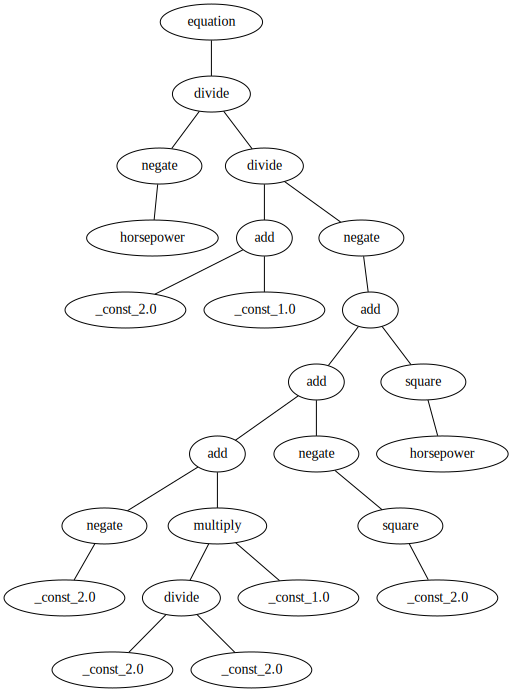

In [10]:
from monkeys.display import node_graph

node_graph(best_equation)

When simplified, the graph above corresponds to the equation:

$y = -\frac{1}{3} x (5 - x^2)$

where $x$ is horsepower and $y$ is miles per gallon.

Finally, let's see how our equation compares against the original data:

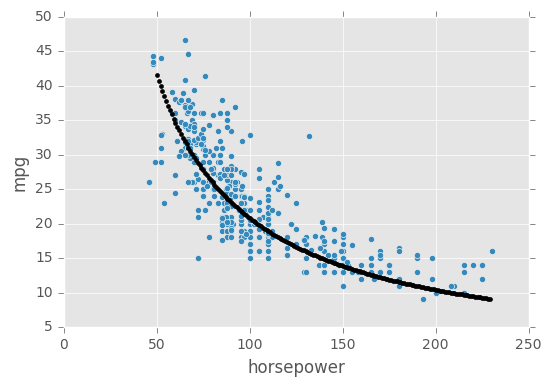

In [11]:
df.plot.scatter(x='horsepower', y='mpg')

predictions = [
    (horsepower, round(best_equation(horsepower=horsepower), 2))
    for horsepower in 
    xrange(50, 230)
]
matplotlib.pyplot.scatter(*zip(*predictions), color='black', s=8)